Mounted at /content/drive
✅ Database initialized.
🧹 Cleaning up old processes...
🔑 Enter your Ngrok Authtoken (input will be hidden):
··········

✅ Dashboard Ready: https://rayne-unerodent-madly.ngrok-free.dev/dashboard/fastapi/fastapi
Scan the QR code below to view:


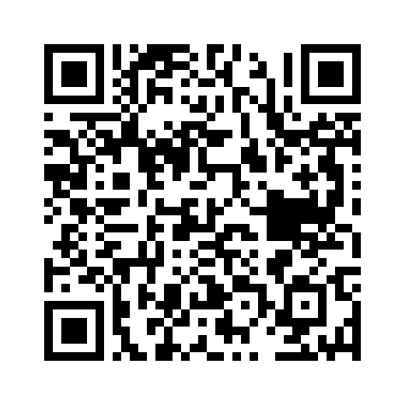

⏳ Poller waiting for server startup...
🚀 Poller started.


/tmp/ipython-input-2814560385.py:148: DeprecationWarning: The default datetime adapter is deprecated as of Python 3.12; see the sqlite3 documentation for suggested replacement recipes
  conn.cursor().executemany(


🔄 Synced 28 events for psf/requests
🔄 Synced 30 events for fastapi/fastapi
🛑 Shutting down.


In [1]:
# --- 1. IMPORTS ---
import os
import sys
import time
import socket
import sqlite3
import asyncio
import threading
import getpass
from datetime import datetime, timedelta, timezone
from typing import Dict, List, Optional, Tuple

# Install requirements quietly
os.system('pip install fastapi uvicorn pyngrok httpx nest_asyncio qrcode[pil]')

import httpx
import uvicorn
import qrcode
import nest_asyncio
import matplotlib.pyplot as plt
from fastapi import FastAPI
from fastapi.responses import HTMLResponse
from pyngrok import ngrok
from google.colab import drive

# --- 2. CONFIGURATION & CONSTANTS ---
DB_PATH = '/content/drive/MyDrive/github_events.db'
REPOS = ["fastapi/fastapi", "psf/requests"]
HOST = "0.0.0.0"
PORT = 8000

# Apply asyncio patch for Colab
nest_asyncio.apply()

# --- 3. DATABASE HANDLING ---
def get_db_connection():
    """Creates and returns a database connection with thread safety disabled for Colab."""
    conn = sqlite3.connect(DB_PATH, check_same_thread=False)
    return conn

def init_db():
    """Initializes the database schema if it doesn't exist."""
    if not os.path.exists('/content/drive'):
        drive.mount('/content/drive')

    conn = get_db_connection()
    cursor = conn.cursor()
    cursor.execute('''
        CREATE TABLE IF NOT EXISTS events (
            id TEXT PRIMARY KEY,
            repo TEXT,
            type TEXT,
            created_at TIMESTAMP
        )
    ''')
    conn.commit()
    conn.close()
    print("✅ Database initialized.")

# Initialize Global DB Connection for the App
# Note: In a production app, we would use dependency injection (Depends) per request.
# For this script, a global connection is acceptable but separated from logic.
init_db()
conn = get_db_connection()
app = FastAPI()

# --- 4. BUSINESS LOGIC ---

def calculate_stats(repo_full: str) -> Dict[str, float]:
    """
    Calculates the average time gap (in seconds) between events for a repo.
    """
    cursor = conn.cursor()

    # Fetch recent events
    query = "SELECT type, created_at FROM events WHERE repo = ? ORDER BY created_at DESC LIMIT 500"
    cursor.execute(query, (repo_full,))
    rows = cursor.fetchall()

    if not rows:
        return {}

    stats = {}
    grouped_events: Dict[str, List[datetime]] = {}

    # Parse timestamps and filter by time (last 7 days)
    # Using timezone awareness handling
    first_dt = datetime.fromisoformat(rows[0][1])
    tz = first_dt.tzinfo or timezone.utc
    cutoff_date = datetime.now(tz) - timedelta(days=7)

    for event_type, created_at_str in rows:
        dt = datetime.fromisoformat(created_at_str)

        if dt < cutoff_date:
            continue

        if event_type not in grouped_events:
            grouped_events[event_type] = []

        grouped_events[event_type].append(dt)

    # Calculate averages
    for event_type, timestamps in grouped_events.items():
        if len(timestamps) < 2:
            continue

        # Difference between newest (index 0) and oldest (index -1) in the batch
        total_diff = timestamps[0] - timestamps[-1]
        avg_seconds = total_diff.total_seconds() / (len(timestamps) - 1)
        stats[event_type] = round(avg_seconds, 2)

    return stats

async def sync_single_repo(client: httpx.AsyncClient, repo: str, etags: Dict[str, str]):
    """
    Fetches events for a single repository and updates the database.
    Reduces nesting in the main polling loop.
    """
    url = f"https://api.github.com/repos/{repo}/events"
    headers = {"If-None-Match": etags.get(repo, "")}

    try:
        resp = await client.get(url, headers=headers)

        if resp.status_code == 304:
            # No new data
            return

        if resp.status_code == 200:
            etags[repo] = resp.headers.get("ETag")
            new_events = []

            for event in resp.json():
                # Fix timezone format for Python isoformat
                created_at = event['created_at'].replace('Z', '+00:00')
                dt = datetime.fromisoformat(created_at)

                new_events.append((
                    event['id'],
                    event['repo']['name'],
                    event['type'],
                    dt
                ))

            # Use a fresh cursor for the write operation
            # INSERT OR IGNORE prevents duplicates efficiently
            conn.cursor().executemany(
                "INSERT OR IGNORE INTO events VALUES (?,?,?,?)",
                new_events
            )
            conn.commit()
            print(f"🔄 Synced {len(new_events)} events for {repo}")

    except Exception as e:
        print(f"⚠️ Error syncing {repo}: {e}")

async def poll_github_loop(server_ready_event: threading.Event):
    """
    Main polling loop. Waits for server to be ready, then polls periodically.
    """
    # Wait until the web server is actually up
    print("⏳ Poller waiting for server startup...")
    server_ready_event.wait(timeout=30)

    async with httpx.AsyncClient() as client:
        etags = {}
        print("🚀 Poller started.")

        while True:
            tasks = [sync_single_repo(client, repo, etags) for repo in REPOS]
            await asyncio.gather(*tasks)
            await asyncio.sleep(60)

# --- 5. API ENDPOINTS ---

@app.get("/dashboard/{owner}/{repo}", response_class=HTMLResponse)
def get_dashboard(owner: str, repo: str):
    repo_full = f"{owner}/{repo}"
    data = calculate_stats(repo_full)

    if not data:
        return "<h1>No data found yet. Please wait for the poller.</h1>"

    labels = list(data.keys())
    values = list(data.values())

    # Keeping the HTML simple inside the f-string for this exercise
    html_content = f"""
    <html>
        <head>
            <title>GitHub Monitor: {repo_full}</title>
            <script src="https://cdn.jsdelivr.net/npm/chart.js"></script>
            <meta name="viewport" content="width=device-width, initial-scale=1">
            <style>
                body {{ font-family: -apple-system, BlinkMacSystemFont, "Segoe UI", Roboto, Helvetica, Arial, sans-serif; padding: 20px; text-align: center; background-color: #f4f4f9; }}
                .chart-container {{ position: relative; height:60vh; width:90vw; margin: auto; background: white; padding: 20px; border-radius: 10px; box-shadow: 0 4px 6px rgba(0,0,0,0.1); }}
                h2 {{ color: #333; }}
            </style>
        </head>
        <body>
            <h2>Activity Gap: {repo_full}</h2>
            <p>Average seconds between events (Lower bar = Higher activity)</p>
            <div class="chart-container">
                <canvas id="myChart"></canvas>
            </div>
            <script>
                const ctx = document.getElementById('myChart');
                new Chart(ctx, {{
                    type: 'bar',
                    data: {{
                        labels: {labels},
                        datasets: [{{
                            label: 'Avg Seconds Between Events',
                            data: {values},
                            backgroundColor: 'rgba(54, 162, 235, 0.6)',
                            borderColor: 'rgba(54, 162, 235, 1)',
                            borderWidth: 1
                        }}]
                    }},
                    options: {{
                        responsive: true,
                        maintainAspectRatio: false,
                        scales: {{ y: {{ beginAtZero: true }} }}
                    }}
                }});
            </script>
        </body>
    </html>
    """
    return html_content

# --- 6. INFRASTRUCTURE & STARTUP ---

def run_uvicorn():
    """Runs the Uvicorn server in a separate thread."""
    config = uvicorn.Config(app, host=HOST, port=PORT, log_level="error")
    server = uvicorn.Server(config)

    loop = asyncio.new_event_loop()
    asyncio.set_event_loop(loop)
    loop.run_until_complete(server.serve())

def setup_ngrok(token: str):
    """Configures and connects Ngrok."""
    ngrok.set_auth_token(token)
    ngrok.kill()

    try:
        tunnel = ngrok.connect(PORT)
        public_url = tunnel.public_url
        dashboard_url = f"{public_url}/dashboard/{REPOS[0]}"

        print(f"\n✅ Dashboard Ready: {dashboard_url}")
        print("Scan the QR code below to view:")

        qr = qrcode.QRCode(box_size=10, border=4)
        qr.add_data(dashboard_url)
        qr.make(fit=True)
        img = qr.make_image(fill_color="black", back_color="white")

        plt.figure(figsize=(5,5))
        plt.imshow(img, cmap='gray')
        plt.axis('off')
        plt.show()

        return True
    except Exception as e:
        print(f"❌ Ngrok Connection Error: {e}")
        return False

def main():
    print("🧹 Cleaning up old processes...")
    os.system(f"fuser -k {PORT}/tcp")

    # 1. Ask for token securely
    print("🔑 Enter your Ngrok Authtoken (input will be hidden):")
    token = getpass.getpass()

    if not token:
        print("❌ Error: No token provided.")
        return

    # 2. Start Server Thread
    server_thread = threading.Thread(target=run_uvicorn, daemon=True)
    server_thread.start()

    # 3. Setup Tunnel
    # Simple check to ensure server thread started
    server_ready = threading.Event()

    # Check for port availability loop
    for _ in range(15):
        try:
            with socket.create_connection(("127.0.0.1", PORT), timeout=1):
                server_ready.set()
                break
        except OSError:
            time.sleep(1)

    if not server_ready.is_set():
        print("❌ Server failed to start in time.")
        return

    if setup_ngrok(token):
        # 4. Start Poller
        try:
            asyncio.run(poll_github_loop(server_ready))
        except KeyboardInterrupt:
            print("🛑 Shutting down.")

if __name__ == "__main__":
    main()